## Predicting All Stars Based of a Full Year of Baseball
Team Members: Chris Spartz, Kevin Gnaster, Zach Josten <br />
Team Number: 31

In [9]:
import numpy as np
import numpy.matlib
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
import scipy.stats as st
import matplotlib.colors as colors
%matplotlib inline
from sklearn.cluster import KMeans
import seaborn as sns; sns.set()
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import statsmodels.formula.api as smf
import statsmodels.api as sm
import math
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression

In [2]:
star = pd.read_excel("FinalDatasetMLBallStar 11.25.21.xlsx")
star.drop(columns=['xwOBA'], inplace=True)
star=star.rename(columns={'All Star Starter?':'ASstarter'})
star.head(5)

,Season,YearName,Name,Team,G,PA,HR,R,RBI,SB,...,OBP,SLG,wOBA,wRC+,BsR,Off,Def,WAR,playerid,ASstarter
0,2019,2019Mike Trout,Mike Trout,LAA,134,600,45,110,104,11,...,0.438,0.645,0.436,177.0,7.1,65.9,-0.3,8.4,10155,1
1,2019,2019Alex Bregman,Alex Bregman,HOU,156,690,41,122,112,5,...,0.423,0.592,0.418,167.0,-2.1,57.3,4.8,8.4,17678,1
2,2019,2019Christian Yelich,Christian Yelich,MIL,130,580,44,100,97,30,...,0.429,0.671,0.442,174.0,8.5,65.2,-3.9,7.8,11477,1
3,2019,2019Cody Bellinger,Cody Bellinger,LAD,156,660,47,121,115,15,...,0.406,0.629,0.415,161.0,1.4,54.2,3.4,7.7,15998,1
4,2019,2019Marcus Semien,Marcus Semien,OAK,162,747,33,123,92,10,...,0.369,0.522,0.373,138.0,1.7,37.7,14.1,7.6,12533,0


In [3]:
star2 = star.dropna(how='any',axis=0).copy()

In [4]:
star2.shape

(20161, 25)

In [5]:
star2.drop(columns=['playerid'], inplace=True)
starCorr=star2.corr()
starCorr.iloc[:,-1:].sort_values(by='ASstarter', ascending=False)

,ASstarter
ASstarter,1.000000
WAR,0.413208
Off,0.402159
HR,0.352875
RBI,0.328526
R,0.319117
PA,0.264179
G,0.226927
SB,0.166729
ISO,0.153212


In [6]:
star3 = star2.loc[star2['PA'] >= 450].reset_index()
star3.shape

(3803, 25)

In [379]:
traditional=["HR","R","RBI","SB","BB%","K%","AVG","OBP","SLG"]
advanced=["ISO","BABIP","wOBA","wRC+","BsR","Off","Def","WAR"]
allStats=["HR","R","RBI","SB","BB%","K%","AVG","OBP","SLG","ISO","BABIP","wOBA","wRC+","BsR","Off","Def","WAR"]
y=star3.ASstarter
#Training testing split is 75-25

In [531]:
bestfeatures = SelectKBest(score_func=f_regression,k=9)
fit = bestfeatures.fit(x,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(x.columns)
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Features','Score'] 
#print(featureScores.nlargest(9,'Score'))
featureScores.nlargest(9,'Score')

,Features,Score
8,SLG,540.708224
7,OBP,458.366828
1,R,434.043321
2,RBI,400.765602
6,AVG,392.610457
0,HR,361.761635
4,BB%,119.048751
5,K%,7.207973
3,SB,6.137440


In [532]:
x = star3[traditional]
x.drop(columns=['K%'], inplace=True)
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.25, random_state = 1)
trainStars = sm.Logit(ytrain, sm.add_constant(xtrain), method='kwargs').fit()
trainStars.summary()

Optimization terminated successfully.
         Current function value: 0.229128
         Iterations 8


C:\Users\Zachary\Anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              ASstarter   No. Observations:                 2852
Model:                          Logit   Df Residuals:                     2843
Method:                           MLE   Df Model:                            8
Date:                Wed, 08 Dec 2021   Pseudo R-squ.:                  0.2629
Time:                        14:22:27   Log-Likelihood:                -653.47
converged:                       True   LL-Null:                       -886.49
Covariance Type:            nonrobust   LLR p-value:                 1.353e-95
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -15.2985      1.084    -14.110      0.000     -17.424     -13.173
HR             0.0831      0.025      3.331      0.001       0.034       0.132
R              0.0132      0.006      2.043      0.041       0.001       0.026
RBI            0.0080      0.006      1.285      0.199      -0.004       0.020
SB             0.0103      0.008      1.325      0.185      -0.005       0.026
BB%           -9.5365      9.946     -0.959      0.338     -29.030       9.957
AVG           21.7076     13.226      1.641      0.101      -4.215      47.630
OBP           20.6879     13.973      1.481      0.139      -6.698      48.074
SLG           -7.3239      3.953     -1.853      0.064     -15.072       0.425
==============================================================================
"""

<AxesSubplot:>

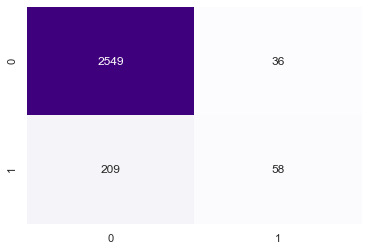

In [524]:
trainPred = trainStars.predict(sm.add_constant(xtrain))
trainPred = round(trainPred)
sns.heatmap(confusion_matrix(ytrain, trainPred), annot=True, cbar=False, fmt='n', cmap='Purples')

In [525]:
print("Training accuracy: ", metrics.accuracy_score(ytrain, trainPred))

Training accuracy:  0.9140953716690042


<AxesSubplot:>

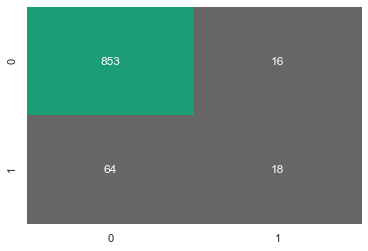

In [526]:
testPred = trainStars.predict(sm.add_constant(xtest))
testPred = round(testPred)
sns.heatmap(confusion_matrix(ytest, testPred), annot=True, cbar=False, fmt='n', cmap='Dark2_r')

In [507]:
print("Testing accuracy: ", metrics.accuracy_score(ytest, testPred))

Testing accuracy:  0.9158780231335436


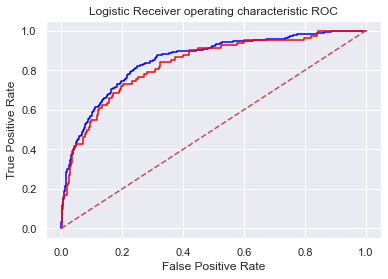

In [508]:
logfprtrain, logtprtrain, thresholds = roc_curve(ytrain, trainStars.predict(sm.add_constant(xtrain)))
logfprtest, logtprtest, thresholds = roc_curve(ytest, trainStars.predict(sm.add_constant(xtest)))
plt.figure()
plt.plot(logfprtrain, logtprtrain, color='blue')
plt.plot(logfprtest, logtprtest, color='red')
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Receiver operating characteristic ROC')
plt.show()

In [509]:
training_roc_auc = roc_auc_score(ytrain, trainStars.predict(sm.add_constant(xtrain)))
training_roc_auc

0.8512347959634596

In [510]:
testing_roc_auc = roc_auc_score(ytest, trainStars.predict(sm.add_constant(xtest)))
testing_roc_auc

0.8317101237755762